# パラメータ化された量子回路

この節ではパラメータ化された量子回路について紹介し、量子機械学習における性質や実装例を説明します。

## イントロダクション

パラメータ化された回路とは調整可能なパラメータを用いて量子ゲートが定義されたもので、目先の量子機械学習アルゴリズムの基礎を担っています。文脈によってはパラメータ化された量子回路はパラメータ化された試行状態・変分形式・ansatzとも呼ぶ文献もあります。

以下はシンプルなパラメータ化された回路の例です。2つのパラメータ化されたゲートがあり、回転角$\theta$の1量子ビットの$z$回転ゲートの後に同じく回転角$\theta$の2量子ビット制御$z$回転ゲートが続いています。

![A quantum circuit with an RZ(theta) gate on qubit 0, followed by an CRZ(theta) controlled by qubit 0, targeting qubit 1](images/pqc/0.svg)

このパラメータ化された回路は`QuantumCircuit`クラスと`Parameter`クラスから生成することが出来ます。`Parameter`クラスでは具体的な回転角を指定せずに回転ゲートを追加することが出来ます。

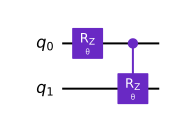

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw()

ゲートに異なるパラメータを渡したい場合は`Parameter`クラスを2つ使うこともできますし、`ParameterVector`という`Parameters`のリストのようなクラスを生成することも出来ます。

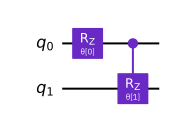

In [2]:
from qiskit.circuit import ParameterVector

theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw()

量子回路内の全ての量子ゲートはユニタリ性を持つので、パラメータ化された回路自体も$n$量子ビットのユニタリ演算子$\mathbf{U_\theta}$と表すことができ、これは初期状態$|\phi_0\rangle$(多くの場合$|0\rangle^{\otimes n}$にセットされる)に作用します。結果として得られるパラメータ化された量子状態は $|\psi_\mathbf{\theta}\rangle = \mathbf{U_\theta} |\phi_0\rangle$となります。ここで$\mathbf{\theta}$は調整可能なパラメータ群です。

<!-- ::: q-block.exercise -->

### Quick quiz

<!-- ::: q-quiz(goal="qml-pqc-0") -->

<!-- ::: .question -->

Why are parameterized quantum circuits useful for near-term machine learning algorithms?

<!-- ::: -->

<!-- ::: .option(correct) -->

1. Parameterized quantum circuits offer a way to implement algorithms on near-term quantum devices.

<!-- ::: -->

<!-- ::: .option -->

2. Parameterized quantum circuits cannot be used to encode classical data.

<!-- ::: -->

<!-- ::: .option -->

3. Parameterized quantum circuits cannot express complex quantum states.

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

## パラメータ化された回路の性質
パラメータ化された回路をいくつかの選択肢から選ぶ場合、どのように選べばよいでしょうか？パラメータ化された回路を量子機械学習モデルとして利用するためには、パラメータ化された回路について適切に一般化する必要があります。これは回路が出力する状態はヒルベルト空間における状態の部分集合となる必要があることを意味します。また、古典コンピュータで容易にシミュレーションできないように回路はエンタングルした量子ビットを持つ必要もあります。

参考文献1において、著者は別々のパラメータ化された回路を区別するために表現能力とエンタングリング能力という指標を提唱しています。回路の表現能力とはヒルベルト空間内に生成可能な状態の範囲と考えることができます。一方で回路のエンタングリング能力とはエンタングルされた状態を生成する能力といえます。

### 表現能力
パラメータ化された回路の表現能力とは本質的には回路の仮説空間によるヒルベルト空間のカバレッジです。高い表現能力を持つパラメータ化された回路は多種多様なユニタリ演算子を表現することが出来ます。表現能力を表す方法はいくつかあり、参考文献1では一つの例が示されています。著者は回路から生成された量子状態の[一様分布](gloss:uniform-distribution)からの偏差を計算することで定量化しています。

次の1量子ビット回路を比較してみて回路の表現能力があるかどうかの勘所を抑えましょう。各回路は2000の出力状態をサンプリングしてブロッホ球上にプロットしています。

![Two single-qubit quantum circuits. Circuit 'A' has one H-gate followed by a RZ(theta) gate. Circuit 'B' has a H-gate, followed by an RZ(theta) gate, followed by an RX(phi) gate.](images/pqc/1.svg)

<!-- ::: q-block -->

### 表現能力の探求

    q-mini-composer(goal="pqc-minicomposer")
        .slide
            .circuit
                .autoMeasureGate
                .availableGates H RZ(theta)
                .initialCircuit
                    .qubit
                .goalCircuit
                    .qubit H RZ(theta)
            .instructions Recreate 'Circuit A'
            .lesson With this circuit, we can only access a small number of states.<br><img src="images/pqc/bloch_a.gif"><br>Above, we've plotted some output states for random values of θ.
            .info Nice one! Let's keep experimenting.
        .slide
            .circuit
                .autoMeasureGate
                .availableGates RX(phi)
                .initialCircuit
                    .qubit H RZ(theta)
                .goalCircuit
                    .qubit H RZ(theta) RX(phi)
            .instructions Recreate 'Circuit B'
            .lesson With this extra gate, we can now access many more states.<br><img src="images/pqc/bloch_b.gif"><br>Above, we've plotted some output states for random values of θ and Φ.
            .info Congrats!
<!-- ::: -->

回路Aでは出力状態がブロッホ球の赤道付近に分布しています。一方でパラメータ化された回転ゲートを加えた回路Bでは出力状態はブロッホ球の全域に分布しています。しかし分布は均一ではなくブロッホ球の$+X$と$-X$の極付近に集中しています。

表現能力はこれらの1量子ビット回路で観察したものを定量化する方法です。回路Aはとり得る状態が限られているため表現能力は低く、一方で回路Bは表現能力が高いと言えます。

<!-- ::: q-block.reminder -->

### Extra code

<details>
    <summary>Code to produce the Bloch sphere plots used in the exercise above</summary>

```python3
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()
```
</details>

<!-- ::: -->

### エンタングリング能力
エンタングルメントは量子コンピューティングにおいて重要です。量子状態のエンタングルの度合いを測る数多くの指標の一つとして[Meyer-Wallach測度](gloss:meyer-wallach-measure)があります。Meyer-Wallach測度はエンタングルされていない[積状態](gloss:product-state)では0ですが、ベル状態など十分エンタングルされた状態では1をとります。参考文献1で、著者はパラメータ化された量子回路のエンタングリング能力を回路から生成し得る状態のMeyer-Wallach測度の平均と定義しています。

例えば以下のような複数量子ビットのパラーメータ化された回路を考えてみます。

![Two four-qubit quantum circuits. Circuit 'A' has an RZ gate on each qubit, followed by an RX gate on each qubit. Circuit 'B' is the same as circuit A, but followed by three additional CNOT gates, acting on qubits 0&1, 2&3, and 1&2 in that order.](images/pqc/2.svg)

回路Aはエンタングル操作、つまり2量子ビットゲートは存在せず、エンタングリング能力はありません。つまりこの回路はMeyer-Wallach測度が0の状態を生成し、その平均値は0ということになります。回路Bはいくつかの2量子ビットが存在するためエンタングルメントを持つ状態が生成することが出来ます。つまりMeyer-Wallach測度の平均値は0より大きいということになります。

表現能力とエンタングル能力という2つのパラメータ化された回路の記述子を用いて回路の能力の限界を知ることが出来ます。限界値の低い回路は量子機械学習への応用として向いてはいません。参考文献2では[変分量子分類器](gloss:variational-quantum-classifier)にてこのことについて研究がされていて、そのデータセットとパラメータ化された回路については、表現能力と分類精度に強い相関が存在すること、また分類精度とエンタングリング能力に弱い相関が存在することが明らかにされています。

### Hardware efficiency

In this era of near term quantum computing, where devices have limited [qubit connectivity](gloss:qubit-connectivity), [coherence times](gloss:coherence-time) and gate fidelities, the depth of the circuits we run directly affects the accuracy of our results, since there is limited error correction or mitigation.

Reference 3 introduces a class of hardware efficient parameterized circuits to accommodate device constraints. The common trait of these circuits is the use of a limited set of quantum gates as well as a particular qubit connection topology. The gate set usually consists of one two-qubit entangling gate and up to three single-qubit gates. The circuit is then constructed from blocks of single-qubit gates and entangling gates, which are applied to multiple or all qubits in parallel. One sequence of a single-qubit and an entangling block is called a layer, and the parameterized circuit generally has multiple layers.

Circuit B depicted in the 'Entangling Capability' section (also shown below) is an example of a single layer hardware efficient parameterized circuit.

## ハードウェア効率
近年の量子コンピューティングの時代では、デバイスは量子ビットの接続に制限が存在しているため、コヒーレンス時間やゲートのフィデリティ、回路の深さが結果の精度に直結します。というのも限られたエラー訂正や緩和の方法しか存在しないからです。

参考文献3ではデバイスの制約に合わせて効率的にパラメータ化した回路群を提唱しています。回路は共通して量子ビットの結合トポロジーだけでなく、量子ゲートも特定のものに絞っているという特徴があります。量子ゲートはたいてい1つの2量子エンタングリングゲートと最大3つの1量子ビットゲートで構成されます。そして回路は1量子ビットゲートとエンタングリングゲートのブロックで組み立てられ、複数または全ての量子ビットに対して並列に適用されます。1量子ビットゲートのブロックとエンタングリングゲートのブロックの並びはレイヤーと呼ばれ、一般にパラメータ化された回路は複数のレイヤーを持ちます。

「エンタングリング容量」の節で登場した回路Bはハードウェア向けに効率化されたレイヤーを1つもつパラメータ化回路の一例です。

![Circuit 'B' has a H-gate, followed by an RZ(theta) gate, followed by an RX(phi) gate.](images/pqc/circuit-b.svg)

<!-- ::: q-block.exercise -->

### Quick quiz

    q-carousel
        q-quiz(goal="qml-pqc-quizousel-0")
            .question.md _Expressibility_ describes...
            .option(x) The extent to which a parameterized circuit is able to generate states within the Hilbert space.
            .option Whether a parameterized circuit can run on near-term quantum hardware or not.
            .option The ability of a parameterized circuit to generate entangled states.

        q-quiz(goal="qml-pqc-quizousel-1")
            .question.md _Entangling capability_ describes...
            .option The extent to which a parameterized circuit is able to generate states within the Hilbert space.
            .option Whether a parameterized circuit can run on near-term quantum hardware or not.
            .option(x) The ability of a parameterized circuit to generate entangled states.

        q-quiz(goal="qml-pqc-quizousel-2")
            .question.md _Hardware efficiency_ describes...
            .option The extent to which a parameterized circuit is able to generate states within the Hilbert space.
            .option(x) Whether a parameterized circuit can run on near-term quantum hardware or not.
            .option The ability of a parameterized circuit to generate entangled states.

<!-- ::: -->

## 機械学習のためのパラメータ化された量子回路

量子機械学習においてパラメータ化された量子回路は以下の2つの用途に用いられることが多いです:

- データのエンコード：パラメータはエンコードされるデータによって決定される
- 量子モデル：パラメータは最適化処理によって決定される

それでは量子機械学習の文献において使われているパラメータ化された回路をQiskitで構築した例をいくつか紹介します。

参考文献4では著者は以下のパラメータ化された回路を導入しています。これはデータをエンコードしていて、詳細は[後ほど](./quantum-feature-maps-kernels)学習します:

$$
\mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right),
$$

上式はアダマールゲートをエンタングリングブロック$U_{\Phi(\mathbf{x})}$で挟んだ層が含まれています。このユニタリ操作が採用されたのは古典コンピュータでは計算が難しく、かつNear-termのハードウェアでは扱うことができるからです。エンタングリングブロックの中で、$U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$はパウリ行列を表し、インデックス$S$は異なる量子ビットの接続を表しています: $S \in \{\binom{n}{k}\ \text{combinations},\ k = 1,... n \}$、またデータマッピング関数$\phi_S(\mathbf{x})$は以下の通りです。
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

具体的にはQiskitの[`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)回路で$k = 2, P_0 = Z, P_1 = ZZ$とした回路を使用しています。



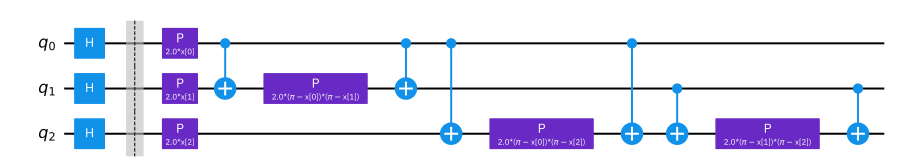

In [3]:
from qiskit.circuit.library import ZZFeatureMap

qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)

qc_zz.decompose().draw()

参考文献4では著者は量子モデルとしてハードウェア効率がよい回路も使用しています。この回路は1量子ビットの回転ゲートにと量子ビットゲートを交互に重ねた層から構成されています。特に$y$軸回転、$z$軸回転、制御$z$軸回転ゲートを使用していて、これは[`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html)回路利用することで構築することが出来ます:

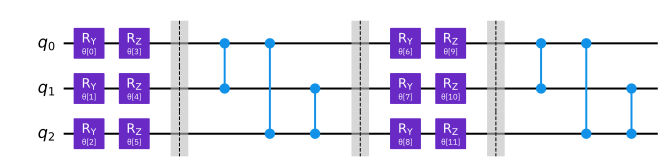

In [4]:
from qiskit.circuit.library import TwoLocal

qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw()

Qiskitの`TwoLocal`回路は様々なパラメータ化された回路を生成することが可能で、例えば参考文献1の回路13も生成することが出来ます。

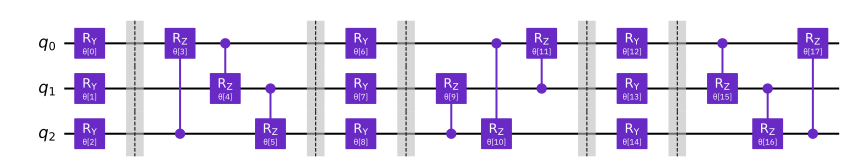

In [5]:
qc_13 = TwoLocal(3, rotation_blocks='ry',
                 entanglement_blocks='crz', entanglement='sca',
                 reps=3, skip_final_rotation_layer=True,
                 insert_barriers=True)

qc_13.decompose().draw()

Qiskitの[`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html)回路でも、回転ゲートの層とエンタングルメント層のより一般的なパラメータ化された回路を生成することも可能です。

こちらが`NLocal`の回路で2量子ビットの回転ブロックと、線形エンタングルメントを用いた4量子ビットのエンタングルメントブロックが存在しています。

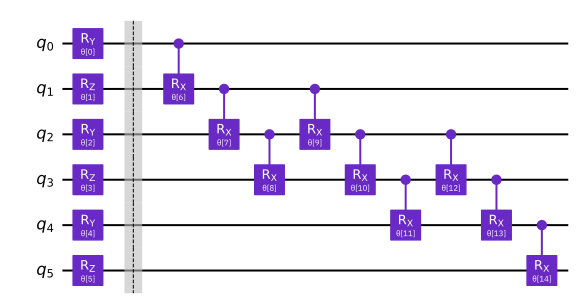

In [6]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw()

<!-- ::: q-block.exercise -->

### Try it

Try build your own parameterized quantum circuit using one of the [NLocal Circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) or [Data Encoding Circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits) in the Qiskit Circuit Library in the [IBM Quantum Lab](https://quantum-computing.ibm.com/lab).

<!-- ::: -->

## References

1. Sukin Sim, Peter D. Johnson and Alan Aspuru-Guzik, *Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms*,  	Advanced Quantum Technology 2 (2019) 1900070, [doi:10.1002/qute.201900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070), [arXiv:1905.10876](https://arxiv.org/abs/1905.10876).
2. Thomas Hubregtsen, Josef Pichlmeier, and Koen Bertels, *Evaluation of Parameterized Quantum Circuits: On the Design, and the Relation between Classification Accuracy, Expressibility and Entangling Capability* 2020, [arXiv:2003.09887](https://arxiv.org/abs/2003.09887).
3. Abhinav Kandala, Antonio Mezzacapo, Kristan Temme, Maika Takita, Markus Brink, Jerry M. Chow and Jay M. Gambetta, *Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets*, Nature 549, 242–246 (2017), [doi.org/10.1038/nature23879](https://doi.org/10.1038/nature23879), [arXiv:1704.05018](https://arxiv.org/abs/1704.05018)
4. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).

In [7]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
